## Multiclass neural classification

Подключаемые модули

In [1]:
import math
import pickle
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, LSTM, SimpleRNN, GRU, Convolution1D, GlobalMaxPooling1D

from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix, roc_curve, roc_auc_score,  \
                            precision_recall_curve, average_precision_score, matthews_corrcoef

In [2]:
%matplotlib inline
%tensorflow_version 2.x
plt.rcParams.update({'font.size': 10})

TensorFlow is already loaded. Please restart the runtime to change versions.


Подгрузка данных о доменных именах с диска 

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
with open('/content/gdrive/My Drive/Colab Notebooks/data/training_data.pkl', 'rb') as f:
  training_data = pickle.load(f)

Общая коллекция данных

In [0]:
# Словарь семей (подтипов DGA)
family_dict = {idx:x for idx, x in enumerate(training_data['dga']['family'].unique())}

In [0]:
classes = len(family_dict)

In [7]:
family_dict

{0: 'Cryptolocker',
 1: 'Post',
 2: 'geodo',
 3: 'dyre',
 4: 'corebot',
 5: 'symmi',
 6: 'nymaim',
 7: 'padcrypt',
 8: 'virut',
 9: 'matsnu',
 10: 'tinba',
 11: 'pushdo',
 12: 'P2P',
 13: 'shifu',
 14: 'shiotob/urlzone/bebloh',
 15: 'banjori',
 16: 'hesperbot',
 17: 'cryptowall',
 18: 'ramnit',
 19: 'dircrypt',
 20: 'ranbyus',
 21: 'simda',
 22: 'pykspa',
 23: 'murofet',
 24: 'locky',
 25: 'Volatile',
 26: 'beebone',
 27: 'bedep',
 28: 'suppobox',
 29: 'fobber',
 30: 'necurs',
 31: 'qakbot',
 32: 'mydoom',
 33: 'tempedreve',
 34: 'ramdo',
 35: 'kraken',
 36: 'bamital',
 37: 'vawtrak',
 38: 'sisron',
 39: 'chinad',
 40: 'gozi',
 41: 'sphinx',
 42: 'proslikefan',
 43: 'vidro',
 44: 'madmax',
 45: 'dromedan',
 46: 'g01',
 47: 'pandabanker',
 48: 'pizd',
 49: 'mirai',
 50: 'tofsee',
 51: 'unknownjs',
 52: 'unknowndropper',
 53: 'MyDoom',
 54: 'Enviserv'}

In [0]:
dga_data_dict = pd.concat([training_data['dga']], ignore_index=True)

In [0]:
# Равномерное распределение сэмлов относительно семейств
dga_data_dict = dga_data_dict.groupby('subtype').apply(lambda x: x.sample(50000, replace=True))

In [10]:
dga_data_dict

domain        family        data  type  subtype
subtype                                                                 
0       44505      jtllsknaqfqf  Cryptolocker  2019-12-02     1        0
        74332   mkcmbcgsfepehcy  Cryptolocker  2019-12-04     1        0
        29639     yliddaubamica  Cryptolocker  2019-12-01     1        0
        45139    pcnblusuhcdxxq  Cryptolocker  2019-12-02     1        0
        30454    egixdelarklisj  Cryptolocker  2019-12-01     1        0
...                         ...           ...         ...   ...      ...
54      871453       4fdeb70f13      Enviserv  2019-12-01     1       54
        871778       a270479f0c      Enviserv  2019-12-01     1       54
        871391       3ea81ec466      Enviserv  2019-12-01     1       54
        871362       36b2dfb041      Enviserv  2019-12-01     1       54
        871844       b36ed525e6      Enviserv  2019-12-01     1       54

[2750000 rows x 5 columns]

In [0]:
# Размеры сэмплов относильельно семейств
# dga_data_dict['family'].value_counts().head(20).plot(kind='barh', figsize=(15,7))

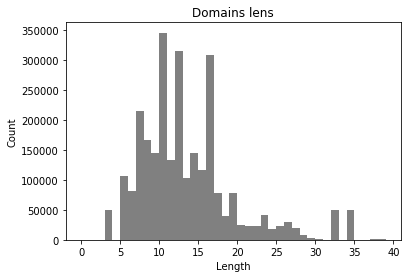

In [12]:
# Распределение длин доменов
# dga_data_dict['domain'].apply(lambda x: np.mean(len(x))).plot(kind='bar', figsize=(15,12), color='Grey')
lens = dga_data_dict.domain.str.len()
plt.hist(lens, bins = np.arange(0,40,1), color='Grey')
plt.title('Domains lens')
plt.ylabel('Count')
plt.xlabel('Length')
plt.show()

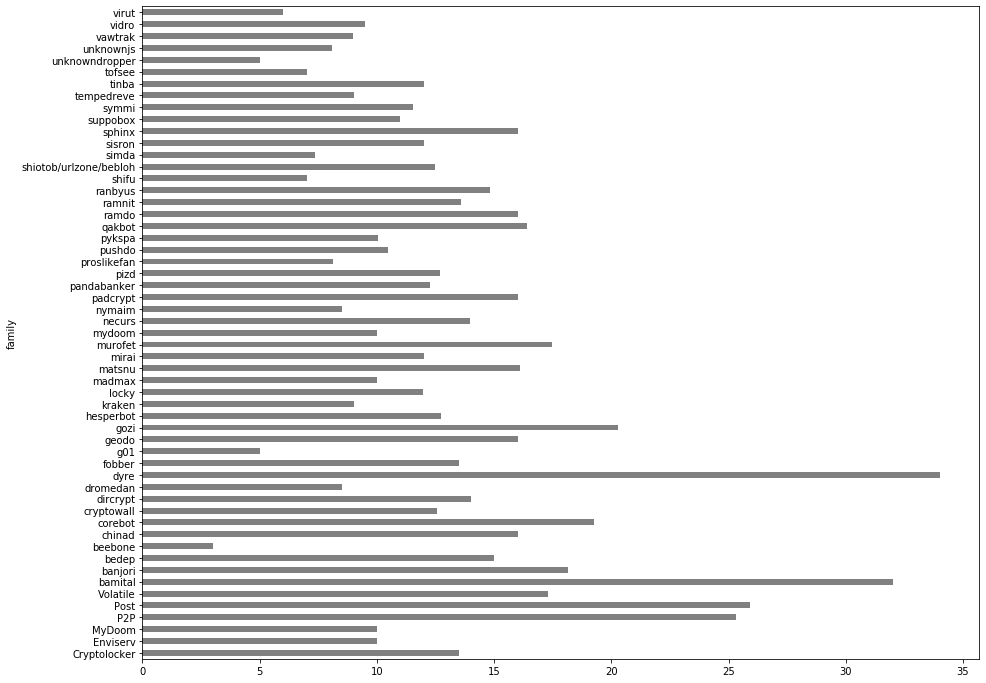

In [13]:
# Распределение длин доменов относительно семейств
dga_data_dict.groupby('family')['domain'].apply(lambda x: np.mean(x.str.len())).plot(kind='barh', figsize=(15,12), color='Grey')

Массивы обучения

In [0]:
# Массив x хранит образцы обучения
# В массиве y хранятся целевые значения (метки типов) для образцов обучения
X_dga = np.array(dga_data_dict['domain'].tolist())
y_dga = np.array(dga_data_dict['subtype'].tolist())

In [15]:
X_dga

array(['jtllsknaqfqf', 'mkcmbcgsfepehcy', 'yliddaubamica', ...,
       '3ea81ec466', '36b2dfb041', 'b36ed525e6'], dtype='<U44')

In [16]:
y_dga

array([ 0,  0,  0, ..., 54, 54, 54])

In [0]:
# Создание словаря действительных символов
valid_chars = {x:idx+1 for idx, x in enumerate(set(''.join(X_dga)))}

In [18]:
valid_chars

{'-': 13,
 '0': 21,
 '1': 17,
 '2': 7,
 '3': 20,
 '4': 37,
 '5': 33,
 '6': 14,
 '7': 31,
 '8': 29,
 '9': 22,
 'a': 2,
 'b': 30,
 'c': 12,
 'd': 24,
 'e': 6,
 'f': 3,
 'g': 26,
 'h': 11,
 'i': 5,
 'j': 4,
 'k': 16,
 'l': 1,
 'm': 32,
 'n': 36,
 'o': 8,
 'p': 15,
 'q': 10,
 'r': 9,
 's': 28,
 't': 27,
 'u': 34,
 'v': 35,
 'w': 23,
 'x': 18,
 'y': 25,
 'z': 19}

In [19]:
# Количество уникальных символов
max_features = len(valid_chars) + 1
max_features

38

In [20]:
# Макс последовательность символов
maxlen = np.max([len(x) for x in X_dga])
maxlen

44

In [0]:
# Преобразование символов в int и pad (последовательности одиннаковой длины)
X_dga = [[valid_chars[y] for y in x] for x in X_dga]
X_dga = sequence.pad_sequences(X_dga, maxlen=maxlen)

In [22]:
X_dga

array([[ 0,  0,  0, ...,  3, 10,  3],
       [ 0,  0,  0, ..., 11, 12, 25],
       [ 0,  0,  0, ...,  5, 12,  2],
       ...,
       [ 0,  0,  0, ..., 37, 14, 14],
       [ 0,  0,  0, ..., 21, 37, 17],
       [ 0,  0,  0, ..., 33,  6, 14]], dtype=int32)

Построение модели

In [0]:
# 20% для теста
X_dga_train, X_dga_test, y_dga_train, y_dga_test = train_test_split(X_dga, y_dga, test_size=0.2, random_state=42)

In [24]:
model_dga = Sequential()
model_dga.add(Embedding(max_features, 128, input_length=maxlen))
model_dga.add(LSTM(128))
model_dga.add(Dropout(rate=0.4))
model_dga.add(Dense(classes))
model_dga.add(Activation('sigmoid'))
model_dga.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['sparse_categorical_accuracy'])
model_dga.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 44, 128)           4864      
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 55)                7095      
_________________________________________________________________
activation (Activation)      (None, 55)                0         
Total params: 143,543
Trainable params: 143,543
Non-tra

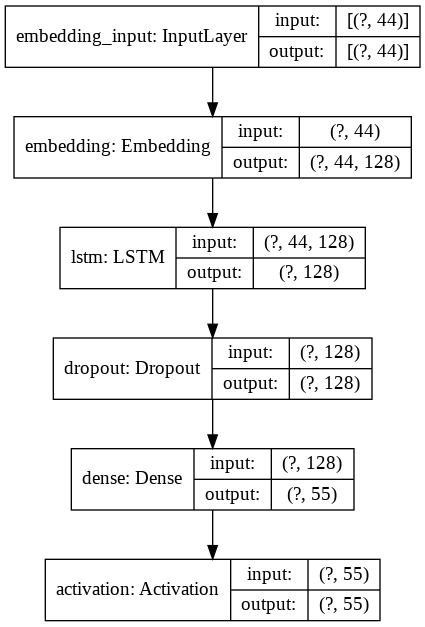

In [25]:
plot_model(model_dga, to_file='model_dga_plot4a.png', show_shapes=True, show_layer_names=True)

In [0]:
# Игнорирование предостережения о нехватке памяти
warnings.filterwarnings('ignore')

Обучение + кросс-валидация

In [27]:
model_dga.fit(X_dga_train, y_dga_train, validation_data=(X_dga_test,y_dga_test), epochs=200, batch_size=16384) #, callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 2200000 samples, validate on 550000 samples
Epoch 1/200
2200000/2200000 [==============================] - 47s 21us/sample - loss: 3.4381 - sparse_categorical_accuracy: 0.0878 - val_loss: 2.8097 - val_sparse_categorical_accuracy: 0.2388
Epoch 2/200
2200000/2200000 [==============================] - 45s 21us/sample - loss: 2.5207 - sparse_categorical_accuracy: 0.2645 - val_loss: 2.1417 - val_sparse_categorical_accuracy: 0.3303
Epoch 3/200
2200000/2200000 [==============================] - 45s 21us/sample - loss: 1.9379 - sparse_categorical_accuracy: 0.4141 - val_loss: 1.6268 - val_sparse_categorical_accuracy: 0.5128
Epoch 4/200
2200000/2200000 [==============================] - 45s 21us/sample - loss: 1.6303 - sparse_categorical_accuracy: 0.5036 - val_loss: 1.4278 - val_sparse_categorical_accuracy: 0.5526
Epoch 5/200
2200000/2200000 [==============================] - 45s 21us/sample - 

In [0]:
model_dga.save('/content/gdrive/My Drive/Colab Notebooks/data/family_prediction_model.h5')

In [29]:
metrics = model_dga.evaluate(X_dga_test, y_dga_test)
print("{}: {}".format(model_dga.metrics_names[0], metrics[0]))
print("{}: {}".format(model_dga.metrics_names[1], metrics[1]))

550000/550000 [==============================] - 311s 565us/sample - loss: 0.3399 - sparse_categorical_accuracy: 0.8782
loss: 0.3398785793632811
sparse_categorical_accuracy: 0.8782236576080322


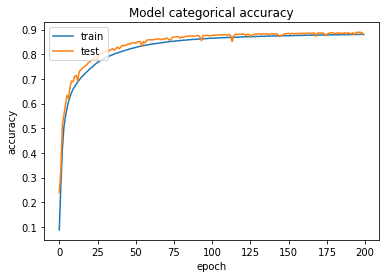

In [30]:
history = model_dga.history

plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])

plt.title('Model categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

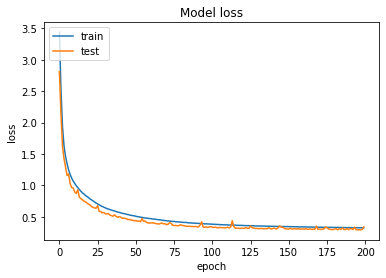

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [32]:
seq = 'hchmemmrsivu'
X_dga_pred = [valid_chars[y] for y in seq]
X_dga_pred = sequence.pad_sequences([X_dga_pred], maxlen=maxlen)
pred_class = model_dga.predict_classes(X_dga_pred)
pred_proba = model_dga.predict_proba(X_dga_pred)
print(family_dict[pred_class[0]])
print(pred_proba[0][pred_class[0]])
print(max(pred_proba[0]))

tinba
0.05747685
0.05747685


Тестирование на отложенной выборке

In [0]:
y_true = y_dga_test
y_pred = model_dga.predict_classes(X_dga_test)
# y_score = model_dga.predict_proba(X_dga_test).round()

In [34]:
print("Accuracy score : ", accuracy_score(y_true, y_pred))
print("Precision score : ", precision_score(y_true, y_pred, average='macro'))
print("Recall score : ", recall_score(y_true, y_pred, average='macro'))
print("F1 score : ", f1_score(y_true, y_pred, average='macro'))
print("MCC score : ", matthews_corrcoef(y_true, y_pred))

Accuracy score :  0.8782236363636363
Precision score :  0.8756392288129456
Recall score :  0.8781114159219401
F1 score :  0.8661894596603736
MCC score :  0.8765489674903197


Матрица ошибок (Confusion Matrix)

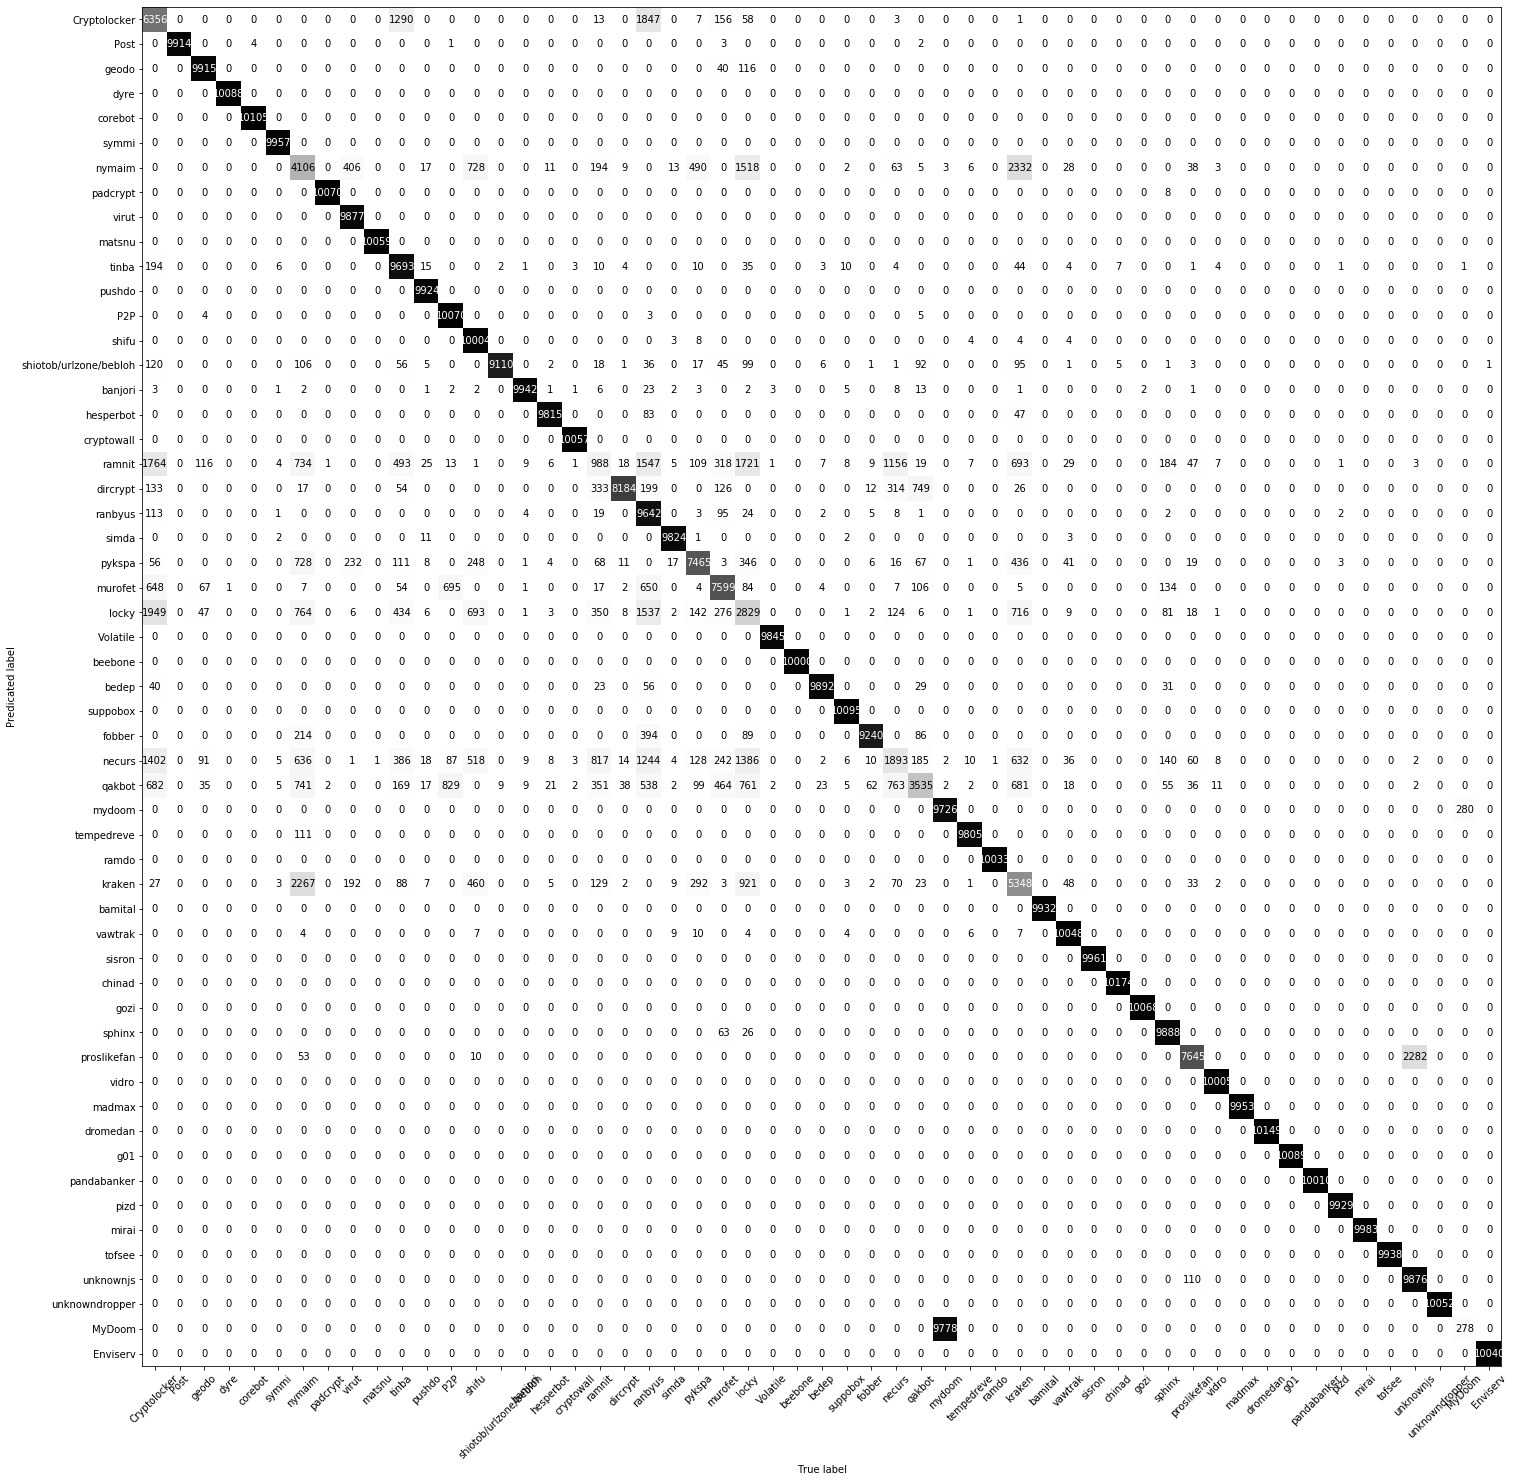

In [35]:
cm = confusion_matrix(y_true, y_pred)

fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(25,25), cmap='Greys')
plt.xticks(list(family_dict.keys()), list(family_dict.values()), rotation=45)
plt.yticks(list(family_dict.keys()), list(family_dict.values()))
plt.xlabel('True label')
plt.ylabel('Predicated label')
fig.savefig('/content/gdrive/My Drive/Colab Notebooks/data/cm.jpg')
plt.show()